In [1]:
# %% [markdown]
# # Diabetes Risk Model Export for Web Deployment
# Finalized model with selected features

# %% [code]
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import joblib
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# %% [code]
# Load dataset and prepare features
df = pd.read_csv('diabetes_012_health_indicators_BRFSS2015.csv')

# Selected features for web form
FEATURE_SET = [
    'HighBP',
    'HighChol',
    'BMI',
    'HeartDiseaseorAttack',
    'GenHlth',
    'PhysHlth',
    'Age',
    'DiffWalk'
]

# Create 4-class target
def create_target(row):
    # No Diabetes (Diabetes_012 == 0)
    if row['Diabetes_012'] == 0:
        return 0  # No Diabetes
    
    # Pre-Diabetes (Diabetes_012 == 1)
    elif row['Diabetes_012'] == 1:
        return 1  # Pre-Diabetes

    # Type 1 Diabetes (Very young, often diagnosed under age 30, and not associated with obesity)
    # Consider: Age < 30 AND BMI is normal (under 25), and no associated conditions like HighBP, HeartDisease
    if row['Age'] < 30 and row['BMI'] < 25 and row['HighBP'] == 0 and row['HeartDiseaseorAttack'] == 0:
        return 2  # Type 1 Diabetes (likely no obesity or metabolic issues)

    # Type 2 Diabetes (Usually older age, BMI ≥ 30, and associated conditions like HighBP or HeartDisease)
    # Type 2 is more common in people older than 40 and with higher BMI
    if row['Age'] >= 40 and row['BMI'] >= 30:
        return 3  # Type 2 Diabetes

    # Type 2 Diabetes (High BMI, or HighBP/HeartDisease risk factors)
    # Age >= 30 with BMI ≥ 25, and any associated conditions like HighBP, Stroke, Smoker, etc.
    elif row['Age'] >= 30 and row['BMI'] >= 25:
        if row['HighBP'] == 1 or row['HeartDiseaseorAttack'] == 1 or row['Stroke'] == 1 or row['Smoker'] == 1:
            return 3  # Type 2 Diabetes (with associated risk factors)
    
    # Type 1 Diabetes (Not linked to obesity, younger age, often diagnosed early)
    # Age < 30 with normal BMI but with other risk factors not present
    elif row['Age'] < 30 and row['BMI'] >= 25:
        return 2  # Type 1 Diabetes is possible (even with higher BMI, diagnosed earlier)
    
    # Additional Case for younger individuals (under age 30) with obesity
    # This is an edge case that might still fit in Type 2 category (increasing in youth)
    elif row['Age'] < 30 and row['BMI'] >= 30:
        return 3  # Type 2 Diabetes, as younger individuals can develop obesity-linked Type 2

    # If age is under 30 but has high-risk factors (e.g., HighBP, Stroke), classify as Type 2
    if row['Age'] < 30 and (row['HighBP'] == 1 and row['HeartDiseaseorAttack'] == 1 or row['Stroke'] == 1):
        return 3  # Type 2 Diabetes due to complications, even in younger age

    # Edge Case for older individuals (between 30-40) with moderate BMI and risk factors
    # Age 30-40 and high BMI or other conditions (risk of Type 2)
    if 30 <= row['Age'] < 40 and (row['BMI'] >= 25 and row['HighBP'] == 1 or row['HeartDiseaseorAttack'] == 1):
        return 3  # Likely Type 2 Diabetes

    # Final fallback: if all conditions are met, return Type 2 (most common form)
    return 3  # Fallback to Type 2 Diabetes

# Apply the function to create the target variable
df['Diabetes_Type'] = df.apply(create_target, axis=1)


# %% [code]
# Prepare final dataset
X = df[FEATURE_SET]
y = df['Diabetes_Type']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## Random Forest Classifier

🟣 Random Forest Classifier Report:
              precision    recall  f1-score   support

 No Diabetes       0.93      0.69      0.79     42741
Pre-Diabetes       0.02      0.09      0.04       926
      Type 1       0.33      0.66      0.44      6508
      Type 2       0.15      0.68      0.24       561

    accuracy                           0.68     50736
   macro avg       0.36      0.53      0.38     50736
weighted avg       0.83      0.68      0.73     50736

✅ Accuracy (Random Forest): 67.69%
Model package successfully exported!

Verification Test Prediction: Type 1 Diabetes


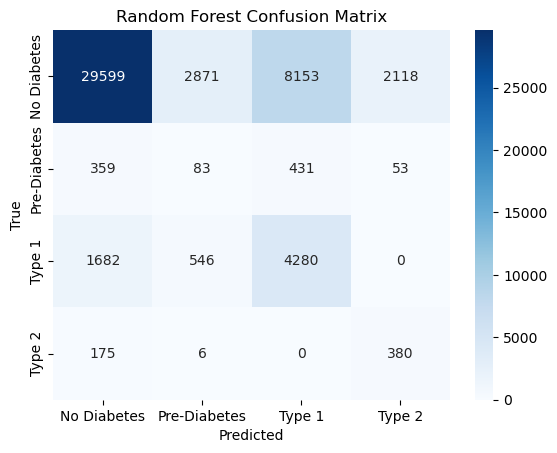

In [2]:
# Train final model
model = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    class_weight='balanced',
    random_state=42
)
model.fit(X_train_scaled, y_train)

# Generate classification report
y_pred = model.predict(X_test_scaled)
accuracy_rf = accuracy_score(y_test, y_pred) * 100
print("🟣 Random Forest Classifier Report:")
print(classification_report(y_test, y_pred, 
    target_names=['No Diabetes', 'Pre-Diabetes', 'Type 1', 'Type 2']))
print(f"✅ Accuracy (Random Forest): {accuracy_rf:.2f}%")

# %% [code]
# Export model artifacts with metadata
model_data = {
    'model': model,
    'scaler': scaler,
    'feature_names': FEATURE_SET,
    'feature_order': FEATURE_SET.copy(),  # Preserve exact order
    'class_names': ['No Diabetes', 'Pre-Diabetes', 'Type 1 Diabetes', 'Type 2 Diabetes']
}

joblib.dump(model_data, 'web_diabetes_model.pkl')
print("Model package successfully exported!")

# %% [code]
# Verification test
loaded_data = joblib.load('web_diabetes_model.pkl')
test_sample = X_test_scaled[0:1]
prediction = loaded_data['model'].predict(test_sample)
print(f"\nVerification Test Prediction: {loaded_data['class_names'][prediction[0]]}")

# Confusion Matrix
rfc_cm = confusion_matrix(y_test, y_pred)
sns.heatmap(rfc_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Diabetes', 'Pre-Diabetes', 'Type 1', 'Type 2'],
            yticklabels=['No Diabetes', 'Pre-Diabetes', 'Type 1', 'Type 2'])
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Gradient Boosting Classifier

🟢 Gradient Boosting Classifier Report:
              precision    recall  f1-score   support

 No Diabetes       0.86      0.98      0.92     42741
Pre-Diabetes       0.00      0.00      0.00       926
      Type 1       0.56      0.19      0.28      6508
      Type 2       0.75      0.01      0.01       561

    accuracy                           0.85     50736
   macro avg       0.54      0.29      0.30     50736
weighted avg       0.81      0.85      0.81     50736

✅ Accuracy (Gradient Boosting): 84.93%
Model package successfully exported!

Verification Test Prediction: No Diabetes


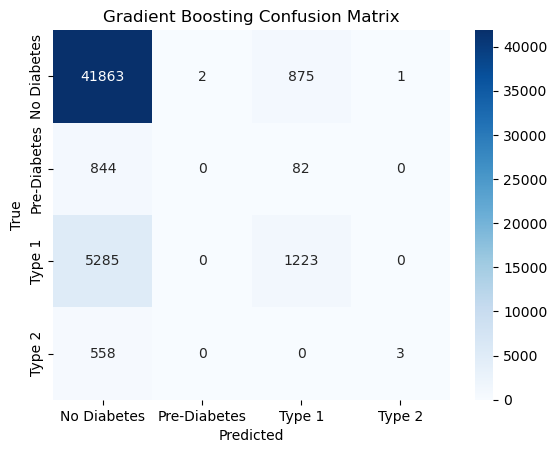

In [5]:
# Import necessary libraries
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import seaborn as sns
import matplotlib.pyplot as plt

# Train final model
model = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
model.fit(X_train_scaled, y_train)

# Generate classification report
y_pred = model.predict(X_test_scaled)
accuracy_gb = accuracy_score(y_test, y_pred) * 100
print("🟢 Gradient Boosting Classifier Report:")
print(classification_report(y_test, y_pred, 
    target_names=['No Diabetes', 'Pre-Diabetes', 'Type 1', 'Type 2']))
print(f"✅ Accuracy (Gradient Boosting): {accuracy_gb:.2f}%")

# %% [code]
# Export model artifacts with metadata
model_data = {
    'model': model,
    'scaler': scaler,
    'feature_names': FEATURE_SET,
    'feature_order': FEATURE_SET.copy(),  # Preserve exact order
    'class_names': ['No Diabetes', 'Pre-Diabetes', 'Type 1 Diabetes', 'Type 2 Diabetes']
}

joblib.dump(model_data, 'web_diabetes_model_gb.pkl')
print("Model package successfully exported!")

# %% [code]
# Verification test
loaded_data = joblib.load('web_diabetes_model_gb.pkl')
test_sample = X_test_scaled[0:1]
prediction = loaded_data['model'].predict(test_sample)
print(f"\nVerification Test Prediction: {loaded_data['class_names'][prediction[0]]}")

# Confusion Matrix
gb_cm = confusion_matrix(y_test, y_pred)
sns.heatmap(gb_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Diabetes', 'Pre-Diabetes', 'Type 1', 'Type 2'],
            yticklabels=['No Diabetes', 'Pre-Diabetes', 'Type 1', 'Type 2'])
plt.title('Gradient Boosting Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


## Comparison

In [7]:
# %% [code]
from sklearn.metrics import accuracy_score

# Accuracy comparison
accuracy_gb = 84.93  # Replace with the actual accuracy from your Gradient Boosting model
accuracy_rf = 67.69  # Replace with the actual accuracy from your Random Forest model

print(f"✅ Accuracy (Gradient Boosting): {accuracy_gb:.2f}%")
print(f"✅ Accuracy (Random Forest): {accuracy_rf:.2f}%")

# Choose the best model based on accuracy
if accuracy_gb > accuracy_rf:
    print("\n🟢 Gradient Boosting is the better model based on accuracy.")
else:
    print("\n🟣 Random Forest is the better model based on accuracy.")

✅ Accuracy (Gradient Boosting): 84.93%
✅ Accuracy (Random Forest): 67.69%

🟢 Gradient Boosting is the better model based on accuracy.
